In [1]:
import tensorflow as tf
from zipfile import ZipFile
import os,glob
import cv2
from tqdm.notebook import tqdm_notebook as tqdm
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Convolution2D, Dropout, Dense,MaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import MaxPooling2D
from keras.layers import Flatten

2023-06-16 09:32:32.966391: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
from zipfile import ZipFile
with ZipFile('/Users/arushigupta/Desktop/Intership/Data/images.zip', 'r') as zipObj:
  
   zipObj.extractall('images')

In [3]:
import Augmentor
p = Augmentor.Pipeline("/Users/arushigupta/Desktop/Intership/Data/images",output_directory="/Users/arushigupta/Desktop/Intership/Output")

p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)

p.zoom(probability=0.3, min_factor=1.1, max_factor=1.6)

p.sample(8000)   

Initialised with 40 image(s) found.
Output directory set to /Users/arushigupta/Desktop/Intership/Output.

Processing <PIL.Image.Image image mode=RGB size=260x260 at 0x1EDE4E7D0>: 100%|██████████| 8000/8000 [00:24<00:00, 328.22 Samples/s]                     


In [4]:
import pathlib
data_dir = pathlib.Path('/Users/arushigupta/Desktop/Intership/Output')
img_height=224
img_width=224

In [5]:
train_ds  = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=32)

Found 8000 files belonging to 2 classes.
Using 6400 files for training.
Metal device set to: Apple M2


2023-06-16 09:32:59.526690: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-06-16 09:32:59.526741: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [6]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=32)

Found 8000 files belonging to 2 classes.
Using 1600 files for validation.


In [7]:
import tensorflow as tf
from tensorflow.keras.layers import Rescaling
normalization_layer = Rescaling(1./255)
normalized_train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
first_image, first_label = next(iter(normalized_train_ds))
print("Pixel value range:")
print(tf.reduce_min(first_image), tf.reduce_max(first_image))

2023-06-16 09:33:00.364941: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [6400]
	 [[{{node Placeholder/_0}}]]
2023-06-16 09:33:00.365374: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [6400]
	 [[{{node Placeholder/_4}}]]


Pixel value range:
tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


In [8]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [9]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from keras.layers import GlobalAveragePooling2D, Flatten, BatchNormalization, Dense, Dropout
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D
base_model1 = InceptionV3(
                    input_shape=(224, 224, 3),
                    weights='imagenet',
                    include_top=False)

In [10]:
# Freeze the first 10 layers
for layer in base_model1.layers[:10]:
    layer.trainable = False
x = base_model1.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.4)(x)
predictions1 = Dense(2, activation='softmax')(x)
model1 = Model(inputs=base_model1.inputs, outputs=predictions1)

In [11]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D
base_model2 = VGG16(
                    input_shape=(224, 224, 3),
                    weights='imagenet',
                    include_top=False)

In [12]:
# Freeze the first 10 layers
for layer in base_model2.layers[:10]:
    layer.trainable = False
x = base_model2.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
predictions2 = Dense(2, activation='softmax')(x)
model2 = Model(inputs=base_model2.inputs, outputs=predictions2)

In [13]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [14]:
model_filepath = "/Users/arushigupta/Desktop/Intership/model-{epoch:02d}-{val_accuracy:.4f}.hdf5"
checkpoint = ModelCheckpoint(
    filepath=model_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

In [15]:
model1.compile(optimizer='adam',loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

model2.compile(optimizer='adam',loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])


In [16]:
history1=model1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=5)

Epoch 1/5


2023-06-16 09:33:03.046975: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [6400]
	 [[{{node Placeholder/_4}}]]
2023-06-16 09:33:03.047202: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [6400]
	 [[{{node Placeholder/_4}}]]
/Users/arushigupta/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits

200/200 [==============================] - ETA: 0s - loss: 0.0717 - accuracy: 0.9812

2023-06-16 09:39:33.678169: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1600]
	 [[{{node Placeholder/_4}}]]
2023-06-16 09:39:33.680164: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1600]
	 [[{{node Placeholder/_4}}]]
2023-06-16 09:39:35.286439: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


200/200 [==============================] - 405s 2s/step - loss: 0.0717 - accuracy: 0.9812 - val_loss: 1.0960 - val_accuracy: 0.7669
Epoch 2/5
200/200 [==============================] - 370s 2s/step - loss: 0.0467 - accuracy: 0.9894 - val_loss: 34.3187 - val_accuracy: 0.8637
Epoch 3/5
200/200 [==============================] - 374s 2s/step - loss: 0.0094 - accuracy: 0.9978 - val_loss: 2.8049e-04 - val_accuracy: 1.0000
Epoch 4/5
200/200 [==============================] - 425s 2s/step - loss: 7.5909e-04 - accuracy: 0.9998 - val_loss: 5.1094e-05 - val_accuracy: 1.0000
Epoch 5/5
200/200 [==============================] - 396s 2s/step - loss: 3.8204e-05 - accuracy: 1.0000 - val_loss: 2.8662e-06 - val_accuracy: 1.0000


In [17]:
model1.save('model1.h5')

In [18]:
import matplotlib.pyplot as plt
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']
loss = history1.history['loss']
val_loss = history1.history['val_loss']

/var/folders/py/xhjr5n9s729_02xr2vxm8km80000gn/T/ipykernel_43973/1687434853.py:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, acc, 'r', label='Training accuracy', color='thistle')
/var/folders/py/xhjr5n9s729_02xr2vxm8km80000gn/T/ipykernel_43973/1687434853.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy', color='orange')


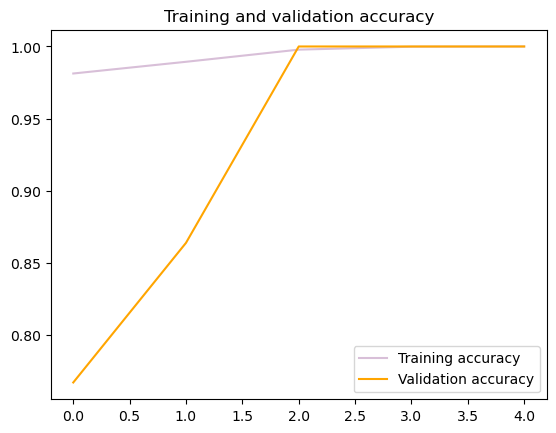

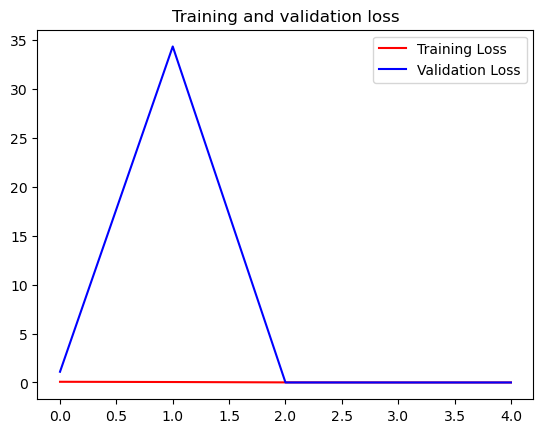

In [19]:
epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy', color='thistle')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy', color='orange')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
history2=model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=5)

Epoch 1/5


/Users/arushigupta/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2023-06-16 10:06:02.814063: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


200/200 [==============================] - ETA: 0s - loss: 2.6258 - accuracy: 0.5109

2023-06-16 10:08:40.677518: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


200/200 [==============================] - 181s 845ms/step - loss: 2.6258 - accuracy: 0.5109 - val_loss: 0.6942 - val_accuracy: 0.4881
Epoch 2/5
200/200 [==============================] - 182s 912ms/step - loss: 0.6929 - accuracy: 0.5083 - val_loss: 0.6937 - val_accuracy: 0.4881
Epoch 3/5
200/200 [==============================] - 158s 792ms/step - loss: 0.6926 - accuracy: 0.5144 - val_loss: 0.6940 - val_accuracy: 0.4881
Epoch 4/5
200/200 [==============================] - 162s 809ms/step - loss: 0.6924 - accuracy: 0.5084 - val_loss: 0.6931 - val_accuracy: 0.5119
Epoch 5/5
200/200 [==============================] - 162s 811ms/step - loss: 0.6922 - accuracy: 0.5192 - val_loss: 0.6937 - val_accuracy: 0.4881


In [21]:
model2.save('model2.h5')

In [22]:
import matplotlib.pyplot as plt
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

<Figure size 640x480 with 0 Axes>

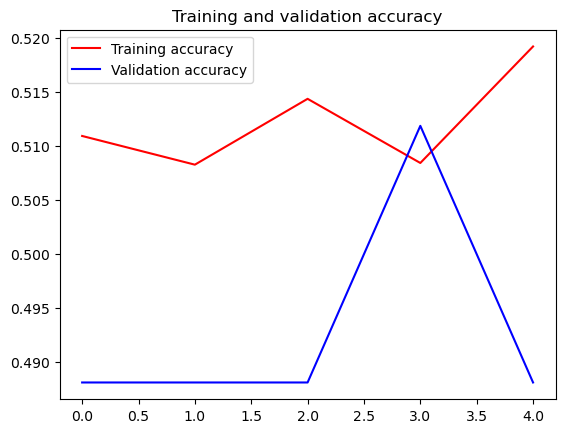

<Figure size 640x480 with 0 Axes>

In [23]:
epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

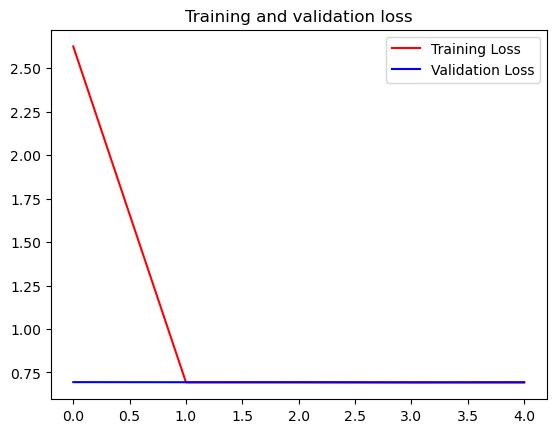

In [24]:
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [27]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Average
model_1 = load_model('/Users/arushigupta/Desktop/Intership/Tires/model1.h5')
model_1 = Model(inputs=model_1.inputs,
                outputs=model_1.outputs,
                name='name_of_model_1')
model_2 = load_model('/Users/arushigupta/Desktop/Intership/Tires/model2.h5')
model_2 = Model(inputs=model_2.inputs,
                outputs=model_2.outputs,
                name='name_of_model_2')
models = [model_1, model_2]
model_input = Input(shape=(224, 224, 3))
model_outputs = [model(model_input) for model in models]
ensemble_output = Average()(model_outputs)
ensemble_model = Model(inputs=model_input, outputs=ensemble_output, name='ensemble')

In [28]:
ensemble_model.compile(optimizer='adam',loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [29]:
history=ensemble_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=5)

Epoch 1/5


2023-06-16 10:32:12.294024: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


200/200 [==============================] - ETA: 0s - loss: 0.2878 - accuracy: 0.9995

2023-06-16 10:42:13.472220: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


200/200 [==============================] - 651s 3s/step - loss: 0.2878 - accuracy: 0.9995 - val_loss: 0.3469 - val_accuracy: 0.9437
Epoch 2/5
200/200 [==============================] - 537s 3s/step - loss: 0.3101 - accuracy: 0.9792 - val_loss: 0.7835 - val_accuracy: 0.5469
Epoch 3/5
200/200 [==============================] - 505s 3s/step - loss: 0.3116 - accuracy: 0.9766 - val_loss: 0.5468 - val_accuracy: 0.7669
Epoch 4/5
200/200 [==============================] - 500s 2s/step - loss: 0.3083 - accuracy: 0.9802 - val_loss: 0.5391 - val_accuracy: 0.7850
Epoch 5/5
200/200 [==============================] - 505s 3s/step - loss: 0.3607 - accuracy: 0.9309 - val_loss: 0.4704 - val_accuracy: 0.8275


In [30]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

In [31]:
epochs = range(len(acc))

<Figure size 640x480 with 0 Axes>

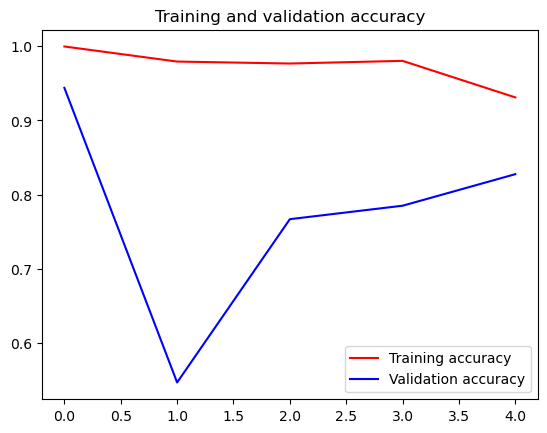

<Figure size 640x480 with 0 Axes>

In [32]:
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

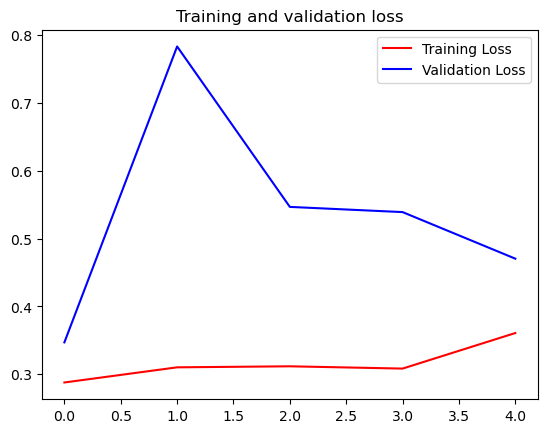

In [33]:
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [34]:
train_label = np.concatenate([y for x, y in train_ds], axis=0)
print(train_label.shape)

test_label = np.concatenate([y for x, y in val_ds], axis=0) 
print(test_label.shape)

(6400,)
(1600,)


In [36]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
#Confution Matrix and Classification Report
import matplotlib.pyplot as plt
Y_pred = ensemble_model.predict_generator(val_ds, 1600)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm=confusion_matrix(test_label, y_pred)
print(cm)
print('Classification Report')
target_names = ['cracked', 'normal']
print(classification_report(test_label, y_pred, target_names=target_names))

/var/folders/py/xhjr5n9s729_02xr2vxm8km80000gn/T/ipykernel_43973/3402159640.py:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = ensemble_model.predict_generator(val_ds, 1600)


Confusion Matrix
[[808  11]
 [265 516]]
Classification Report
              precision    recall  f1-score   support

     cracked       0.75      0.99      0.85       819
      normal       0.98      0.66      0.79       781

    accuracy                           0.83      1600
   macro avg       0.87      0.82      0.82      1600
weighted avg       0.86      0.83      0.82      1600



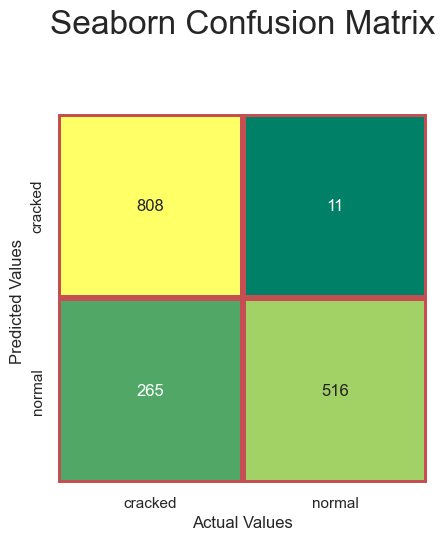

In [44]:
import seaborn as sns
sns.set(font_scale=1.0)
ax=sns.heatmap(cm, annot=True, cmap='summer', cbar=False, linewidths=3, linecolor='r', square=True, xticklabels=target_names,yticklabels=target_names,fmt='')
#sns.heatmap(cm, annot=True,annot_kws={"size": 22})
sns.set(font_scale = 2.0)
ax.set_title('Seaborn Confusion Matrix\n\n');
ax.set_xlabel('Actual Values')
ax.set_ylabel('Predicted Values ');